In [1]:
cd /g/data/jk72/deg581/apom/ana/notebooks

/g/data/jk72/deg581/apom/ana/notebooks


In [2]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import matplotlib.ticker as mticker

## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

'/jobfs/130315229.gadi-pbs'

In [3]:
def _distq(lon1, lat1, lon2, lat2):
    """
    Compute the geodesic distance between lat/lon points. This code is
    taken from the dist.f routine and the Matlab version distg.m passed
    around WHOI and APL. This was stripped down to use the WGS84 ellipsoid.

    Parameters
    ----------
    lon1 : array_like or scalar
        Input array of source longitude(s)
    lat1 : array_like or scalar
        Input array of source latitude(s)
    lon2 : array_like or scalar
        Input array of destination longitude(s)
    lat2 : array_like or scalar
        Input array of destination latitude(s)

    Returns
    -------
    distance : array or scalar of distance in meters
    angle: array or scalar of angle in radians

    """
    lon1 = np.asanyarray(np.radians(lon1))
    lat1 = np.asanyarray(np.radians(lat1))
    lon2 = np.asanyarray(np.radians(lon2))
    lat2 = np.asanyarray(np.radians(lat2))

    # # If one of the points is a singleton and the other is an
    # array, make them the same size
    if lon1.size == 1 and lon2.size > 1:
        lon1 = lon1.repeat(lon2.size)
        lat1 = lat1.repeat(lat2.size)
    if lon2.size == 1 and lon1.size > 1:
        lon2 = lon2.repeat(lon1.size)
        lat2 = lat2.repeat(lat1.size)

    # Set the WGS84 parameters
    A = 6378137.
    E = 0.081819191
    B = np.sqrt(A * A - (A * E)**2)
    EPS = E * E / (1.0 - E * E)

    # Move any latitudes off of the equator
    lat1[lat1 == 0] = np.finfo(float).eps
    lat2[lat2 == 0] = -np.finfo(float).eps

    # COMPUTE THE RADIUS OF CURVATURE IN THE PRIME VERTICAL FOR EACH POINT
    xnu1 = A / np.sqrt(1.0 - (E * np.sin(lat1))**2)
    xnu2 = A / np.sqrt(1.0 - (E * np.sin(lat2))**2)

    TPSI2 = (1.0 - E * E) * np.tan(lat2) + E * E * xnu1 * np.sin(lat1) / \
        (xnu2 * np.cos(lat2))
    PSI2 = np.arctan(TPSI2)

    DPHI2 = lat2 - PSI2
    DLAM = (lon2 - lon1) + np.finfo(float).eps
    CTA12 = np.sin(DLAM) / (np.cos(lat1) * TPSI2 - np.sin(lat1) * np.cos(DLAM))
    A12 = np.arctan(CTA12)
    CTA21P = np.sin(DLAM) / (np.sin(PSI2) * np.cos(DLAM) -
                            np.cos(PSI2) * np.tan(lat1))
    A21P = np.arctan(CTA21P)

    # C    GET THE QUADRANT RIGHT
    DLAM2 = (np.abs(DLAM) < np.pi).astype(int) * DLAM + \
        (DLAM >= np.pi).astype(int) * (-2 * np.pi + DLAM) + \
        (DLAM <= -np.pi).astype(int) * (2 * np.pi + DLAM)
    A12 = A12 + (A12 < -np.pi).astype(int) * 2 * np.pi - \
        (A12 >= np.pi).astype(int) * 2 * np.pi
    A12 = A12 + np.pi * np.sign(-A12) * \
        (np.sign(A12).astype(int) != np.sign(DLAM2))
    A21P = A21P + (A21P < -np.pi).astype(int) * 2 * np.pi - \
        (A21P >= np.pi).astype(int) * 2 * np.pi
    A21P = A21P + np.pi * np.sign(-A21P) * \
        (np.sign(A21P).astype(int) != np.sign(-DLAM2))

    SSIG = np.sin(DLAM) * np.cos(PSI2) / np.sin(A12)

    dd1 = np.array([np.cos(lon1) * np.cos(lat1),
                    np.sin(lon1) * np.cos(lat1), np.sin(lat1)])
    dd2 = np.array([np.cos(lon2) * np.cos(lat2),
                    np.sin(lon2) * np.cos(lat2), np.sin(lat2)])
    dd2 = np.sum((dd2 - dd1)**2, axis=0)
    bigbrnch = (dd2 > 2).astype(int)

    SIG = np.arcsin(SSIG) * (bigbrnch == 0).astype(int) + \
        (np.pi - np.arcsin(SSIG)) * bigbrnch

    SSIGC = -np.sin(DLAM) * np.cos(lat1) / np.sin(A21P)
    SIGC = np.arcsin(SSIGC)
    A21 = A21P - DPHI2 * np.sin(A21P) * np.tan(SIG / 2.0)

    # C   COMPUTE RANGE
    G2 = EPS * (np.sin(lat1))**2
    G = np.sqrt(G2)
    H2 = EPS * (np.cos(lat1) * np.cos(A12))**2
    H = np.sqrt(H2)
    SIG2 = SIG * SIG
    TERM1 = -H2 * (1.0 - H2) / 6.0
    TERM2 = G * H * (1.0 - 2.0 * H2) / 8.0
    TERM3 = (H2 * (4.0 - 7.0 * H2) - 3.0 * G2 * (1.0 - 7.0 * H2)) / 120.0
    TERM4 = -G * H / 48.0
    rng = xnu1 * SIG * (1.0 + SIG2 * (TERM1 + SIG * TERM2 + SIG2 * TERM3 +
                                    SIG2 * SIG * TERM4))

    return rng, A12


def earth_angle(lon1, lat1, lon2, lat2):
    """
    Compute the angle between lat/lon points. NOTE: The bearing angle
    is computed, but then converted to geometric (counter-clockwise)
    angle to be returned.

    Parameters
    ----------
    lon1 : array_like or scalar
        Input array of source longitude(s)
    lat1 : array_like or scalar
        Input array of source latitude(s)
    lon2 : array_like or scalar
        Input array of destination longitude(s)
    lat2 : array_like or scalar
        Input array of destination latitude(s)

    Returns
    -------
    angle : array or scalar of bearing in radians

    """
    _, angle = _distq(lon1, lat1, lon2, lat2)
    # return (np.pi / 2.0 - angle)
    return (angle)



In [4]:

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)

# map u,v to rho points
def ROMSmetricsAndGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    print('making pm/pn metrics')
    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)
    print('making dx/dy')
    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

#     ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
#     ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
#     ds['dz_u'] = grid.interp(ds.dz, 'X')
#     ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
#     ds['dz_v'] = grid.interp(ds.dz, 'Y')
#     ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        # ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds,grid



def add_zeros_to_4(date):
    if date<10:
        to_add = '000'
    elif date>9 & date<100:
        to_add = '00'
    elif date>99 & date < 1000:
        to_add = '0'
    else: 
        to_add = ''
    return to_add

def generateFileList(FilePath,prefix,datelist):
    filelist=[FilePath+prefix+add_zeros_to_4(datelist[0])+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=FilePath+prefix+add_zeros_to_4(dates)+str(dates)+'.nc'
        filelist.append(filenameToAppend)
    return filelist

### load data sets

In [5]:
grd = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_v13_grd.nc')


In [6]:


FilePath='/g/data/gv90/bkg581/prd_amery/amery_CTRL/' # Truth file settings
prefix='roms_avg_'
timeRange = [49, 54]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

ds['dz'] = (('s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w0,axis=0))


ds, grid = ROMSmetricsAndGrid(ds)

print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')

ds_CTRL = ds

ds.close()

['/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0049.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0050.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0051.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0052.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0053.nc']
259.204128416 G
159.673446416 G
making vertical coordinates
making pm/pn metrics
making dx/dy
mapping u/v to u/v rho


In [7]:


FilePath='/g/data/jk72/deg581/apom/mdl/amery_AIS2/' # Truth file settings
prefix='roms_avg_'
timeRange = [49, 54]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

ds['dz'] = (('s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w0,axis=0))

ds, grid = ROMSmetricsAndGrid(ds)

print('correctly mask melt')
ds['m'] = ds.m*ds.mask_ziceNaN
ds['my'] = ds.m*(60*60*24*365)


print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')

ds_AIS2 = ds

ds.close()

['/g/data/jk72/deg581/apom/mdl/amery_AIS2/roms_avg_0049.nc', '/g/data/jk72/deg581/apom/mdl/amery_AIS2/roms_avg_0050.nc', '/g/data/jk72/deg581/apom/mdl/amery_AIS2/roms_avg_0051.nc', '/g/data/jk72/deg581/apom/mdl/amery_AIS2/roms_avg_0052.nc', '/g/data/jk72/deg581/apom/mdl/amery_AIS2/roms_avg_0053.nc']
259.204128416 G
159.673446416 G
making vertical coordinates
making pm/pn metrics
making dx/dy
correctly mask melt
mapping u/v to u/v rho


In [8]:


FilePath='/g/data/jk72/deg581/apom/mdl/amery_AIS05/' # Truth file settings
prefix='roms_avg_'
timeRange = [49, 54]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

ds['dz'] = (('s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w0,axis=0))

ds, grid = ROMSmetricsAndGrid(ds)

print('correctly mask melt')
ds['m'] = ds.m*ds.mask_ziceNaN
ds['my'] = ds.m*(60*60*24*365)


print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')

ds_AIS05 = ds

ds.close()

['/g/data/jk72/deg581/apom/mdl/amery_AIS05/roms_avg_0049.nc', '/g/data/jk72/deg581/apom/mdl/amery_AIS05/roms_avg_0050.nc', '/g/data/jk72/deg581/apom/mdl/amery_AIS05/roms_avg_0051.nc', '/g/data/jk72/deg581/apom/mdl/amery_AIS05/roms_avg_0052.nc', '/g/data/jk72/deg581/apom/mdl/amery_AIS05/roms_avg_0053.nc']
259.204128416 G
159.673446416 G
making vertical coordinates
making pm/pn metrics
making dx/dy
correctly mask melt
mapping u/v to u/v rho


In [9]:


FilePath='/g/data/gv90/bkg581/prd_amery/amery_MKPA/' # Truth file settings
prefix='roms_avg_'
timeRange = [49, 54]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

ds['dz'] = (('s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w0,axis=0))


ds, grid = ROMSmetricsAndGrid(ds)

print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')

ds_MKPA = ds

ds.close()

['/g/data/gv90/bkg581/prd_amery/amery_MKPA/roms_avg_0049.nc', '/g/data/gv90/bkg581/prd_amery/amery_MKPA/roms_avg_0050.nc', '/g/data/gv90/bkg581/prd_amery/amery_MKPA/roms_avg_0051.nc', '/g/data/gv90/bkg581/prd_amery/amery_MKPA/roms_avg_0052.nc', '/g/data/gv90/bkg581/prd_amery/amery_MKPA/roms_avg_0053.nc']
259.204128416 G
159.673446416 G
making vertical coordinates
making pm/pn metrics
making dx/dy
mapping u/v to u/v rho


In [10]:
print(' make dayofyear means ')
print(' have to first fix the time coordinate to ignore the leap year. sigh.')

No_of_years=5
dayofyear = np.concatenate([np.array((356,361)),np.tile(np.arange(1,365,5),No_of_years-1),np.arange(1,365-10,5)])
dayofyear_da = xr.DataArray(dayofyear,[('day',dayofyear)])

ds_CTRL['day']=dayofyear_da
ds_CTRL['salt_doy']=ds_CTRL.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_CTRL['temp_doy']=ds_CTRL.temp.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_CTRL['u_rho_doy']=ds_CTRL.u_rho.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_CTRL['v_rho_doy']=ds_CTRL.v_rho.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()


ds_AIS2['day']=dayofyear_da
ds_AIS2['salt_doy']=ds_AIS2.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_AIS2['temp_doy']=ds_AIS2.temp.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_AIS2['u_rho_doy']=ds_AIS2.u_rho.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_AIS2['v_rho_doy']=ds_AIS2.v_rho.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()


ds_AIS05['day']=dayofyear_da
ds_AIS05['salt_doy']=ds_AIS05.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_AIS05['temp_doy']=ds_AIS05.temp.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_AIS05['u_rho_doy']=ds_AIS05.u_rho.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_AIS05['v_rho_doy']=ds_AIS05.v_rho.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()


ds_MKPA['day']=dayofyear_da
ds_MKPA['salt_doy']=ds_MKPA.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_MKPA['temp_doy']=ds_MKPA.temp.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_MKPA['u_rho_doy']=ds_MKPA.u_rho.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_MKPA['v_rho_doy']=ds_MKPA.v_rho.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()

 make dayofyear means 
 have to first fix the time coordinate to ignore the leap year. sigh.


In [11]:
prefix_name='AIS2'
ds = ds_AIS2

del ds_AIS2

/jobfs/130315229.gadi-pbs/ipykernel_2149978/4242197625.py:96: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  p = cs.collections[0].get_paths()[0]


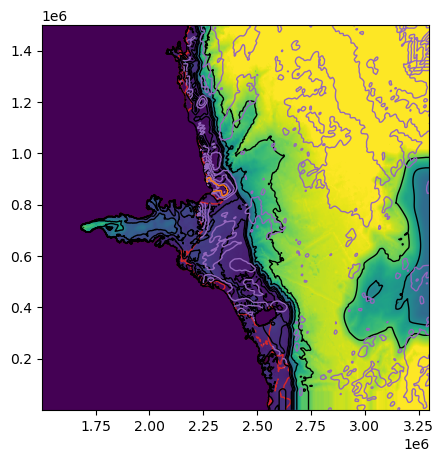

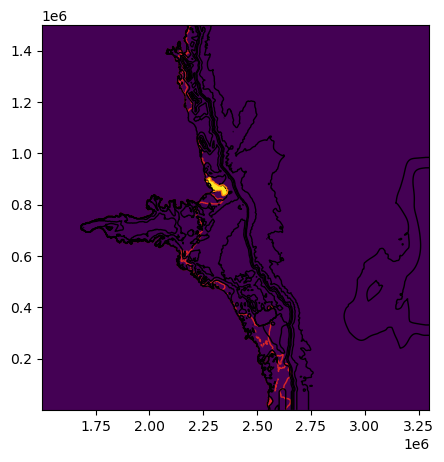

In [12]:

grd['hc']=ds.hc
grd['s_w']=ds.s_w
grd['s_rho']=ds.s_rho
grd['Cs_w']=ds.Cs_w
grd['Cs_r']=ds.Cs_r



# make grid masks


grd['mask_zice'] = (grd.mask_rho.where(grd.zice<0)==1) # make a logic mask for ice
grd['mask_openocean'] = grd.mask_rho*(grd.mask_zice==0)
grd['mask_openoceanNaN'] = grd.mask_openocean.where(grd.mask_openocean)
grd['mask_rhoNaN'] = grd.mask_rho.where(grd.mask_rho)
grd['mask_ziceNaN'] = grd.mask_zice.where(grd.mask_zice)

# amery mask

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])

mask_roi = inpolygon(grd.x_rho.values, grd.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])
grd['mask_zice_roi'] = grd.mask_zice*mask_roi
roi_label1 = 'amery'
grd.mask_zice_roi.attrs['long_name']=roi_label1

# polyna-center masks

ds_his = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_tamura+era_swflux.nc')
swflux = ds_his["swflux"] 
ds_his.close()
del ds_his


plotting=False
if plotting==True:
    plt.figure(figsize=(5,5))
    plt.pcolormesh(ds.h*ds.mask_rho)
    plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
    co2 = plt.contour(ds.h*ds.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
    plt.contour(swflux.mean(dim='swf_time')*ds.mask_openoceanNaN,levels=5,colors='C4',linestyles='-',linewidths=1)
    plt.plot(394,438,'x')
    plt.plot(364,393,'x')
    plt.plot(391,461,'x')
    plt.colorbar()
    plt.axis((300,500,250,500))

mask_burton_center = np.zeros_like(grd.lon_rho)
mask_burton_center[461:461+4,391:391+4]=1

mask_capedarnley_center = np.zeros_like(grd.lon_rho)
mask_capedarnley_center[437:437+4,393:393+4]=1

mask_mackenzie_center = np.zeros_like(grd.lon_rho)
mask_mackenzie_center[392:392+4,363:363+4]=1

mask_fasticetongue = np.zeros_like(grd.lon_rho)
mask_fasticetongue[400:425,367:425]=1
mask_fasticetongue = mask_fasticetongue*grd.mask_zice

if plotting==True:
    plt.figure(figsize=(5,5))
    plt.pcolormesh(mask_fasticetongue*ds.zice,vmin=-10,vmax=0)
    plt.colorbar()
    plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
    plt.axis((300,500,250,500))


# make polynya-area masks


ds_his = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_tamura+era_swflux.nc')
swflux = ds_his["swflux"] 
ds_his.close()
del ds_his


mask_capedarnley_tempo = np.zeros_like(grd.lon_rho)
mask_capedarnley_tempo[410:460,380:450]=1

plt.figure(figsize=(5,5))
plt.pcolormesh(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho)
plt.contour(grd.x_rho,grd.y_rho,grd.zice*grd.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
co2 = plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN,levels=5,colors='C4',linestyles='-',linewidths=1)

cs = plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN*mask_capedarnley_tempo,levels=[2.8e-7],colors='C1',linestyles='-',linewidths=1) # units of m/s

# paths = cs.get_paths()[0].to_polygons()
# plt.plot(paths[1][:,0],paths[1][:,1])
p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]
mask_capedarnley_tempo2 = inpolygon(grd.x_rho.values, grd.y_rho.values, x, y)


plt.figure(figsize=(5,5))
plt.contour(grd.x_rho,grd.y_rho,grd.zice*grd.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
co2 = plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
cs = plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN*mask_capedarnley_tempo,levels=[2.8e-7],colors='C1',linestyles='-',linewidths=1) # units of m/s

plt.pcolormesh(grd.x_rho,grd.y_rho,mask_capedarnley_tempo2*grd.mask_openocean)

mask_capedarnley = mask_capedarnley_tempo2*grd.mask_openocean
grd['mask_capedarnley'] = mask_capedarnley
# define weighting parameters

weights = (1/grd.pm)*(1/grd.pn)
weights.name = "weights"



### finished preliminary loading data

In [13]:
# define time periods
winter_period=slice(51,64)
summer_period=slice(14,27)

print(ds_CTRL.dayofyear.isel(dayofyear=winter_period)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=winter_period)[-1].values)
print(ds_CTRL.dayofyear.isel(dayofyear=summer_period)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=summer_period)[-1].values)

winter_period_doy=slice(49,62)
summer_period_doy=slice(12,25)

print(ds_CTRL.dayofyear.isel(dayofyear=winter_period_doy)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=winter_period_doy)[-1].values)
print(ds_CTRL.dayofyear.isel(dayofyear=summer_period_doy)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=summer_period_doy)[-1].values)

print('PROBABLY  SHOULD REDEFINE WINTER PERIOD WITH THE NEW DAYOFYEAR DATA')


256  to  316
71  to  131
246  to  306
61  to  121
PROBABLY  SHOULD REDEFINE WINTER PERIOD WITH THE NEW DAYOFYEAR DATA


In [14]:
%%time

# dump the big fields
ds = ds.drop_vars(['m','Tstar','Ustar','u','v','temp','salt','rho','zeta','Tb','my'])
print(ds.nbytes/1e9,'G')
ds.load()

86.093373352 G
CPU times: user 8min 44s, sys: 13min 40s, total: 22min 24s
Wall time: 14min 47s


<xarray.Dataset>
Dimensions:            (tracer: 2, boundary: 4, s_rho: 31, s_w: 32,
                        eta_rho: 750, xi_rho: 900, xi_u: 899, eta_v: 749,
                        ocean_time: 365, day: 365, dayofyear: 73)
Coordinates: (12/17)
  * s_rho              (s_rho) float64 -0.9839 -0.9516 ... -0.04839 -0.01613
  * s_w                (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.03226 0.0
    x_rho              (eta_rho, xi_rho) float64 1.501e+06 ... 3.299e+06
    y_rho              (eta_rho, xi_rho) float64 1e+03 1e+03 ... 1.499e+06
    x_u                (eta_rho, xi_u) float64 1.502e+06 1.504e+06 ... 3.298e+06
    y_u                (eta_rho, xi_u) float64 1e+03 1e+03 ... 1.499e+06
    ...                 ...
    lon_rho            (eta_rho, xi_rho) float64 89.96 89.96 ... 65.55 65.56
    lat_rho            (eta_rho, xi_rho) float64 -76.25 -76.23 ... -57.53 -57.51
    z_w0               (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.0 0.0
    z_rho0             (s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... -3.873
  * day                (day) int64 356 361 1 6 11 16 ... 326 331 336 341 346 351
  * dayofyear          (dayofyear) int64 1 6 11 16 21 26 ... 341 346 351 356 361
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/97)
    ntimes             int32 131400
    ndtfast            int32 40
    dt                 float64 240.0
    dtfast             float64 6.0
    dstart             datetime64[ns] 2007-01-01
    nHIS               int32 1800
    ...                 ...
    u_rho              (ocean_time, s_rho, eta_rho, xi_rho) float32 nan ... nan
    v_rho              (ocean_time, s_rho, eta_rho, xi_rho) float32 nan ... 0...
    salt_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 nan ... 34.3
    temp_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 nan ... 1.206
    u_rho_doy          (dayofyear, s_rho, eta_rho, xi_rho) float32 nan ... nan
    v_rho_doy          (dayofyear, s_rho, eta_rho, xi_rho) float32 nan ... 0....
Attributes: (12/35)
    file:              roms_avg_0049.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             Amery Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 4.1, Thursday - October 17, 2024 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       AMERY, ADD_FSOBC, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL,...

In [15]:
%%time

# calculate potential density

import seawater as sw

sigma_0 = np.ones((ds.s_rho.size,ds.dayofyear.size,ds.eta_rho.size,ds.xi_rho.size))*np.NaN
for nn in range(len(ds.s_rho)):
    print(nn)
    sigma_0[nn,:,:,:] = sw.pden(ds.salt_doy.isel(s_rho=nn).values,sw.temp(ds.salt_doy.isel(s_rho=nn).values,ds.temp_doy.isel(s_rho=nn).values, \
                                                                             ds.z_rho0.isel(s_rho=nn).values),ds.z_rho0.isel(s_rho=nn).values,0)-1000
sigma_0 = np.transpose(sigma_0,(1,0,2,3))
ds['sigma_0_doy']=(('dayofyear','s_rho','eta_rho','xi_rho'),sigma_0)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
CPU times: user 11min 38s, sys: 6min 26s, total: 18min 5s
Wall time: 18min 5s


Text(0.5, 1.0, 'Bottom potential density anom (kg/m$^3$)')

<Figure size 640x480 with 0 Axes>

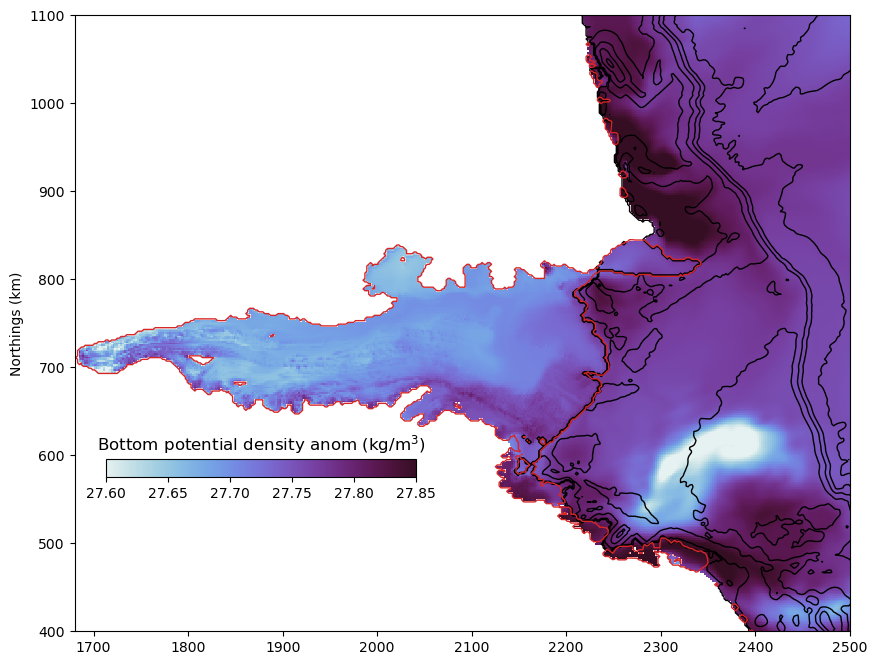

In [16]:
# test plot bottom-layer density

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,8])
ax = None
winter_period
ax=fig.add_subplot(gs[0,0])

im2 = ds.sigma_0_doy.isel(s_rho=-1).isel(dayofyear=winter_period).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.dense',\
                                                                                                  vmin=27.6,vmax=27.85,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds.h*ds.mask_rho*(ds.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.1e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')


# cax = inset_axes(ax,
#                 width="40%",  # width = 10% of parent_bbox width
#                 height="3%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(.04,.1, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im1, cax=cax, orientation='horizontal') 
# cax.set_title(r'annual-mean melt rate (m/yr)')



cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'Bottom potential density anom (kg/m$^3$)')


# annotations


27.6
27.62
27.64
27.66
27.68
27.7
27.72
27.74
27.759999999999998
27.779999999999998
27.799999999999997
27.819999999999997
27.839999999999996
27.859999999999996
27.879999999999995
27.899999999999995
27.919999999999995
27.939999999999994
27.959999999999994
27.979999999999993
27.999999999999993
28.019999999999992
28.039999999999992
28.05999999999999
28.07999999999999
28.09999999999999
28.11999999999999
28.13999999999999
28.15999999999999
28.17999999999999


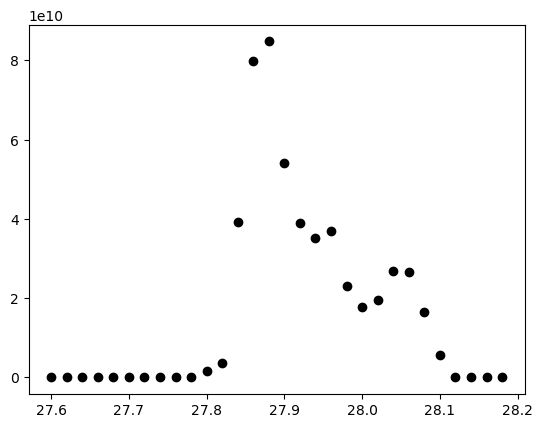

In [25]:
depth_res = 0.02
plt.figure()
for depth_class in np.arange(27.6,28.2,depth_res):
    print(depth_class)
    val= (((ds.sigma_0_doy.isel(dayofyear=55).where(mask_capedarnley)>depth_class) & (ds.sigma_0_doy.isel(dayofyear=55).where(mask_capedarnley)<=depth_class+depth_res))*ds.dz*ds.dA).sum(('s_rho','eta_rho','xi_rho')) 
    plt.plot(depth_class,val,'k-o')
    # print(
# (ds.sigma_0_doy.isel(dayofyear=55).where(mask_capedarnley)*ds.dz*ds.dA).sum(('s_rho','eta_rho','xi_rho'))

#### Calculate cross-shelf transport

<timed exec>:37: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.


USING THE ANGLE BETWEEN-MODEL-POINTS
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
CPU times: user 35.5 s, sys: 2.38 s, total: 37.8 s
Wall time: 38.9 s


<Figure size 640x480 with 0 Axes>

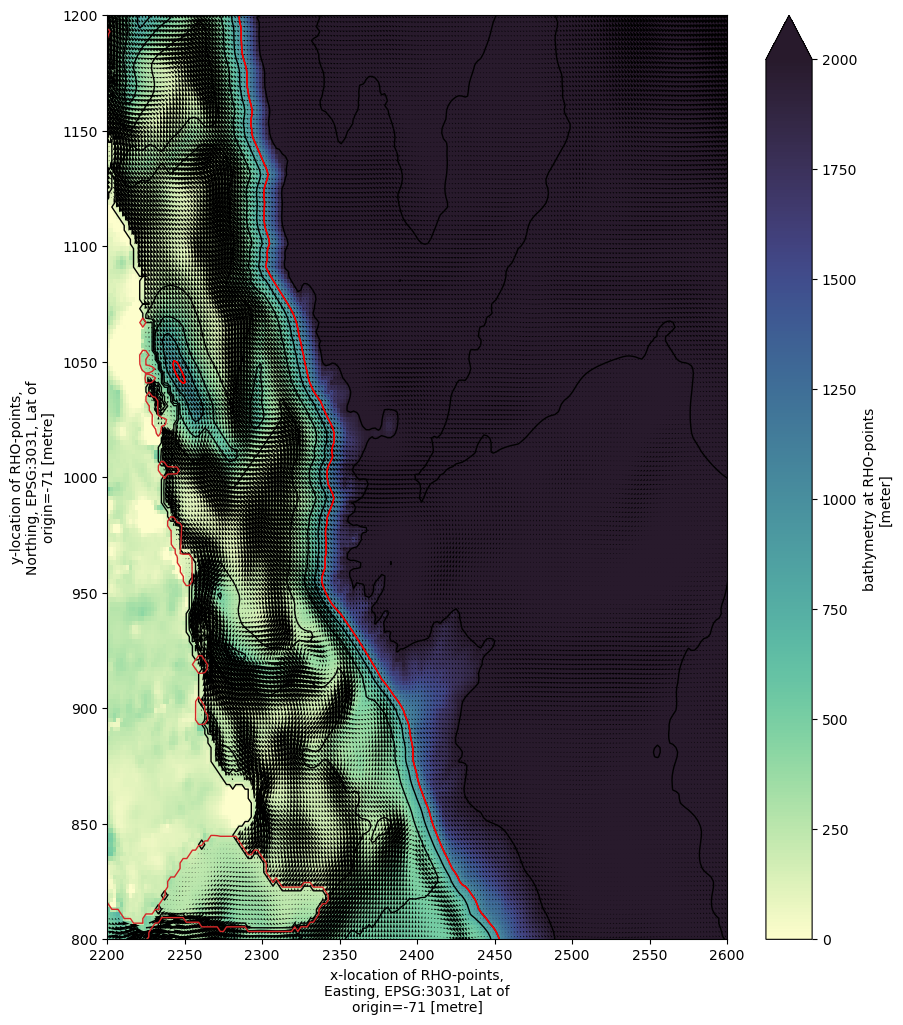

In [26]:
%%time
# now re-write all of that into a single cell that can be plopped in another notebook.

##### 1. first make contour
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,12])
ax = None
winter_period
ax=fig.add_subplot(gs[0,0])

im2 = ds.h.plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.deep',vmin=0,vmax=2000,add_colorbar=True)
co2 = (ds.h*ds.mask_rho*(ds.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co2 = (ds.h*ds.mask_rho*(ds.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=[1000],colors='r',linestyles='-',linewidths=1)
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
qui = plt.quiver(ds.x_rho,ds.y_rho,ds.u_rho_doy.isel(s_rho=-1).isel(dayofyear=winter_period).mean(dim='dayofyear'),ds.v_rho_doy.isel(s_rho=-1).isel(dayofyear=winter_period).mean(dim='dayofyear'),scale=8,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.8e6,1.2e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')


##### 2. Extract contour data

level = 1000
cs = (ds.h*ds.mask_rho*(ds.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=[level],colors='r',linestyles='-',linewidths=1)
p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]

##### 3. Cut down contour to single line.

cont_where = ((x>2.3e6) & (x<2.45e6)) & ((y>.85e6) & (y<1.2e6)) # cut dow

if plotting:
    plt.plot(x[cont_where],y[cont_where],'r')

##### 4. Now convert ps to lat lon and calculate bearing.

from pyproj import Transformer
from pyproj import CRS
from pyproj import Geod
geodesic = Geod(ellps='WGS84')

ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")


cont_lat,cont_lon = ps_to_ll.transform(x[cont_where],y[cont_where]) # now convert those contour points to lat/lon
cont_x = x[cont_where]
cont_y = y[cont_where]
# Calculate the angle between the points, the rad angle along the contour
fwd_azimuth,back_azimuth,distance = geodesic.inv(cont_lon[:-1], cont_lat[:-1], cont_lon[1:], cont_lat[1:]) 

az_rad = np.deg2rad(fwd_azimuth)

if plotting:
    plt.show()
    plt.plot(fwd_azimuth)

    plt.show()
    plt.plot(cont_lon,cont_lat)
    plt.axis('equal')

    plt.show()
    plt.plot(cont_x,cont_y)
    plt.axis('equal')


#### 5. Now work out which model points are closest to our contour values.
## thank eff for chatgpt. These distances, calculated with the planar difference, are probably cose enough to be accurate.

y_grid = ds.y_rho.values
x_grid = ds.x_rho.values

coordinates = np.column_stack((cont_y, cont_x)) # Coordinates array to find closest indices for

closest_indices = [] # Initialize arrays to store closest indices

for coord in coordinates:
    y_point, x_point = coord
    # Calculate distances from each point in lon_grid and lat_grid
    distances = np.sqrt((y_grid - y_point)**2 + (x_grid - x_point)**2)
    # Find the indices of the minimum distance
    closest_idx = np.unravel_index(np.argmin(distances), distances.shape)
    closest_indices.append(closest_idx)

# Convert result to a numpy array
closest_indices = np.array(closest_indices)

cont_xi = closest_indices[:,1] # axes are reversed to what you'd expect.
cont_eta= closest_indices[:,0]

if plotting:
    plt.plot(cont_xi,cont_eta)

##### 6. Now find which actual x_rho and y_rho points these xi,eta points correspond to.
cont_xi_x = np.empty_like(cont_x)
cont_eta_y= np.empty_like(cont_x)

for ii in range(len(cont_xi)):
    cont_xi_x[ii] = ds.x_rho.isel(xi_rho=cont_xi[ii],eta_rho=cont_eta[ii]).values
    cont_eta_y[ii] = ds.y_rho.isel(xi_rho=cont_xi[ii],eta_rho=cont_eta[ii]).values

##### 6b. And find the actual lon/lat these points correspond to.
cont_xi_lat = np.empty_like(cont_x)
cont_eta_lon= np.empty_like(cont_x)
for ii in range(len(cont_xi)):
    cont_xi_lat[ii] = ds.lat_rho.isel(xi_rho=cont_xi[ii],eta_rho=cont_eta[ii]).values
    cont_eta_lon[ii] = ds.lon_rho.isel(xi_rho=cont_xi[ii],eta_rho=cont_eta[ii]).values

if plotting:    
    plt.plot(cont_xi_x,cont_eta_y)
    plt.plot(cont_x,cont_y,'r')
    plt.plot(x[cont_where],y[cont_where],'k')

    plt.axis('equal')

##### 7. Now subset the velocity values along the contour

# extract velocities at these points
u_rho_cont = np.empty((len(ds.dayofyear),len(ds.s_rho),len(cont_xi)))*np.NaN
v_rho_cont = np.empty((len(ds.dayofyear),len(ds.s_rho),len(cont_xi)))*np.NaN
h_cont = np.empty((len(cont_xi)))*np.NaN


for ii in range(len(cont_xi)):
    u_rho_cont[:,:,ii] = ds.u_rho_doy.isel(xi_rho=cont_xi[ii],eta_rho=cont_eta[ii]).values
    v_rho_cont[:,:,ii] = ds.v_rho_doy.isel(xi_rho=cont_xi[ii],eta_rho=cont_eta[ii]).values
    h_cont[ii] = ds.h.isel(xi_rho=cont_xi[ii],eta_rho=cont_eta[ii]).values

# now we have the u_rho and v_rho velocities along the contour (noting that these are velocities relative to the model grid directions
#  so on the PS grid. I could rotate these to the lat/lon grid, or I could rotate them to be along/across the 
#  shelf break contour


##### 8. Adjust the angles to have the correct rotation and positivity.
option_Angle='along_model_contour'
# now we have the azimuth of the contour in radians az_rad.
if option_Angle=='along_plot_contour':
    print('USING THE ANGLE ALONG-EXACT-CONTOUR')
    test= -(np.pi/2 - az_rad) # 90deg - angle (all in rads) to convert to rads away from 0==east.
elif option_Angle=='along_model_contour':
    print('USING THE ANGLE BETWEEN-MODEL-POINTS')
    fwd_azimuth,back_azimuth,distance = geodesic.inv(cont_eta_lon[:-1], cont_xi_lat[:-1], cont_eta_lon[1:], cont_xi_lat[1:]) 
    az_rad = np.deg2rad(fwd_azimuth)
    test= -(np.pi/2 - az_rad) # 90deg - angle (all in rads) to convert to rads away from 0==east.
# I need to add a zero at the end to account for the last angle being missing
#  also use it as a test value. 
# NOTE: make negative to account for +east going clockwise, and positive angles going anti-clockwise
cont_angle = np.concatenate([test, np.pi/2+np.ones(1)*np.pi/4])

if plotting:
    plt.quiver(cont_x,cont_y,np.zeros(len(u_rho_cont[55,-1,:])),v_rho_cont[55,-1,:],color='r')
    plt.quiver(cont_x,cont_y,u_rho_cont[55,-1,:],np.zeros(len(v_rho_cont[55,-1,:])),color='b')
    plt.quiver(cont_x,cont_y,u_rho_cont[55,-1,:],v_rho_cont[55,-1,:])
    plt.show()


##### 9. Make unit vector and initialise 
# constract unit vector
cont_angle_ux = np.sin(cont_angle)
cont_angle_uy = np.cos(cont_angle)
magnitude = np.sqrt(cont_angle_ux**2 + cont_angle_uy**2) # should already all be ones
cont_angle_ux = cont_angle_ux/magnitude
cont_angle_uy = cont_angle_uy/magnitude



vel_para = np.empty_like(u_rho_cont)*np.NaN
vel_perp = np.empty_like(u_rho_cont)*np.NaN
a_dot_b_parallel = np.zeros((len(ds.dayofyear),len(ds.s_rho),len(cont_angle_ux),2))*np.NaN
a_dot_b_perp = np.zeros((len(ds.dayofyear),len(ds.s_rho),len(cont_angle_ux),2))*np.NaN

##### 10. Do the dot product and store outputs.

for tt in range(len(ds.dayofyear)):
    print(tt)
    for ss in range(len(ds.s_rho)):
        for ii in range(len(cont_angle_ux)):
            a=np.array((u_rho_cont[tt,ss,ii],v_rho_cont[tt,ss,ii]))
            b=np.array((cont_angle_ux[ii],cont_angle_uy[ii]))
            
            a_dot_b_parallel[tt,ss,ii,:] = ((np.dot(a, b) / np.dot(b, b)) * b)
            a_dot_b_perp[tt,ss,ii,:] = a- ((np.dot(a, b) / np.dot(b, b)) * b)
            
            vel_para[tt,ss,ii] = np.linalg.norm(a_dot_b_parallel[tt,ss,ii,:])
            vel_perp[tt,ss,ii] = np.linalg.norm(a_dot_b_perp[tt,ss,ii,:])
            
            u1 = a / np.linalg.norm(a)
            u2 = b / np.linalg.norm(b)

            minor = np.linalg.det(np.stack((u1, u2)))

            angle_diff = np.rad2deg(np.sign(minor) * np.arccos(np.clip(np.dot(u1, u2), -1.0, 1.0)))
            
            angle_diff = angle_diff % 360
            
            if (angle_diff>=0) & (angle_diff<90):
                # do nothing
                1+1
            elif (angle_diff>=90) & (angle_diff<180):
                vel_para[tt,ss,ii] = -1*vel_para[tt,ss,ii] 
                vel_perp[tt,ss,ii] = vel_perp[tt,ss,ii] 
            elif (angle_diff>=180) & (angle_diff<270):
                vel_para[tt,ss,ii] = -1*vel_para[tt,ss,ii] 
                vel_perp[tt,ss,ii] = -1*vel_perp[tt,ss,ii] 
            elif (angle_diff>=270) & (angle_diff<360):
                vel_para[tt,ss,ii] = vel_para[tt,ss,ii] 
                vel_perp[tt,ss,ii] = -1*vel_perp[tt,ss,ii] 
            else:
                print(angle_diff)




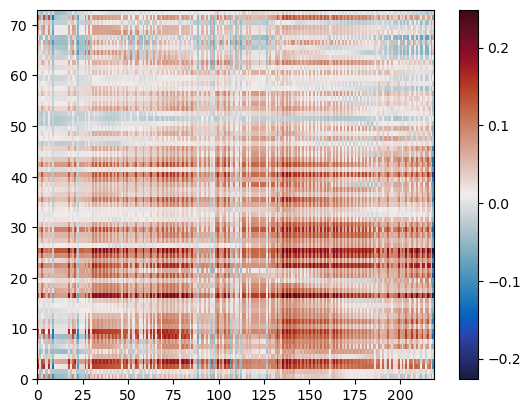

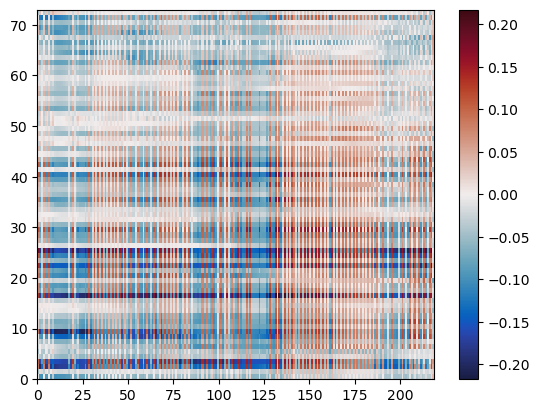

In [27]:
### test plot the perp/parallel velocities
plt.pcolormesh(vel_para[:,-1,:],cmap='cmo.balance')
plt.colorbar()
plt.show()
plt.pcolormesh(vel_perp[:,-1,:],cmap='cmo.balance')
plt.colorbar()
plt.show()


#### Now make density classes again, but scale by cross-velocity too

In [28]:

# extract densities at these points
dens_cont = np.empty((len(ds.dayofyear),len(ds.s_rho),len(cont_xi)))*np.NaN


for ii in range(len(cont_xi)):
    dens_cont[:,:,ii] = ds.sigma_0_doy.isel(xi_rho=cont_xi[ii],eta_rho=cont_eta[ii]).values


/jobfs/130315229.gadi-pbs/ipykernel_2149978/2989660439.py:2: RuntimeWarning: invalid value encountered in multiply
  dens_cont = np.empty((len(ds.dayofyear),len(ds.s_rho),len(cont_xi)))*np.NaN


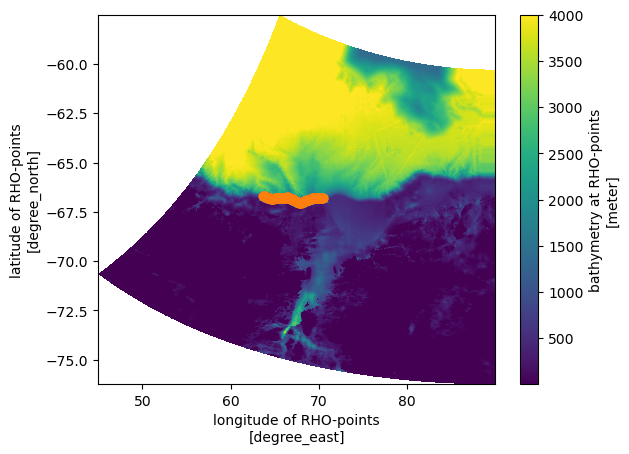

In [29]:
#double checking what the difference is between cont_lon/lat and cont_eta_lon/lat.
# cont_lon and cont_x etc are the points of the contour, which aren't at the exact cell centers.
#%matplotlib widget
ds.h.plot(x='lon_rho',y='lat_rho')
plt.plot(cont_lon,cont_lat,'x')
plt.plot(cont_eta_lon,cont_xi_lat,'o')


In [30]:
# now calculate the distance between points

#cont_xi_x
#cont_eta_y

#first check that lat/lon from inverse is same as grid points

print(cont_lat[0:5],cont_lon[0:5]) #= ps_to_ll.transform(x[cont_where],y[cont_where]) # now convert those contour points to lat/lon

cont_xi_lat = np.empty_like(cont_x)
cont_eta_lon= np.empty_like(cont_x)
for ii in range(len(cont_xi)):
    cont_xi_lat[ii] = ds.lat_rho.isel(xi_rho=cont_xi[ii],eta_rho=cont_eta[ii]).values
    cont_eta_lon[ii] = ds.lon_rho.isel(xi_rho=cont_xi[ii],eta_rho=cont_eta[ii]).values

print(cont_xi_lat[0:5],cont_eta_lon[0:5])
print('the above two vectors show lat diffs between model points and contour points')

dump1,dump2,distances = geodesic.inv(cont_eta_lon[:-1], cont_xi_lat[:-1], cont_eta_lon[1:], cont_xi_lat[1:]) 
dC = np.concatenate([distances, np.ones(1)*2000]) # add a default 2000m distance onto end. Thus distance has the same length as the contour vector.
dZ = np.ones((len(ds.s_rho),len(dC)))*np.NaN

for ii in range(len(cont_xi)):
    dZ[:,ii] = ds.dz.isel(xi_rho=cont_xi[ii],eta_rho=cont_eta[ii]).values
    
print('now plot what the locations and distances and dZ are:')
print(cont_eta_lon[-10:])
print(cont_xi_lat[-10:])
print(dC[-10:])
print(dZ[-1,-10:])

print('note that any zero distances are because the dx2+dy2 distance calculation above found that the closest model point to a contour point was same as previous. \
If we keep this 0 in the distance dC vector, then the doubled velocity found in the vel perp vector should be removed')

[-66.69596651 -66.69490527 -66.69348411 -66.69116519 -66.69103962] [63.69938615 63.72004208 63.75227833 63.80187539 63.80508783]
[-66.69186525 -66.69186525 -66.69969409 -66.69164476 -66.69164476] [63.70450355 63.70450355 63.74454475 63.80433625 63.80433625]
the above two vectors show lat diffs between model points and contour points
now plot what the locations and distances and dZ are:
[70.24504009 70.30242143 70.30242143 70.34466676 70.40198888 70.40198888
 70.44425146 70.50151406 70.50151406 70.54379362]
[-66.80966069 -66.79897879 -66.79897879 -66.8049356  -66.79421456
 -66.79421456 -66.80014231 -66.7893822  -66.7893822  -66.79528088]
[2790.14742986    0.         1972.91548403 2790.10005571    0.
 1972.88174149 2790.05199159    0.         1972.8475111  2000.        ]
[4.40636428 4.58674324 4.58674324 4.36723076 4.51361984 4.51361984
 4.3308128  4.55997088 4.55997088 4.39631776]
note that any zero distances are because the dx2+dy2 distance calculation above found that the closest mode

In [31]:
 geodesic.inv((70.30242143), -66.79897879 ,  70.30242143, -66.79897879) 

(0.0, 180.0, 0.0)

In [32]:
# vel_perp[20,-1,-10:]
# u_rho_cont[20,-1,-10:]
print(dump1[-10:])
print(cont_angle[-11:-1])
print(-(np.pi/2 - np.deg2rad(dump1[-10:])))


[  0.          64.75264069   0.         109.69587077  64.65301548
   0.         109.59630193  64.55343224   0.         109.49677535]
[-1.57079633 -0.44064955 -1.57079633  0.34375779 -0.44238834 -1.57079633
  0.34201999 -0.44412639 -1.57079633  0.34028292]
[-1.57079633 -0.44064955 -1.57079633  0.34375779 -0.44238834 -1.57079633
  0.34201999 -0.44412639 -1.57079633  0.34028292]


In [33]:
%%time

depth_res = 0.02
density_classes = np.arange(27.6,28.04,depth_res)
plt.figure()

trans_dens_cross = np.empty((len(ds.dayofyear),len(density_classes),len(ds.s_rho),len(cont_xi)))*np.NaN

for tt in range(len(ds.dayofyear)):
    # print(tt)
    for pp,depth_class in enumerate(density_classes):
        # print(depth_class)
        # trans_dens[tt,pp] = (((ds.sigma_0_doy.isel(dayofyear=tt).where(mask_capedarnley)>depth_class) & (ds.sigma_0_doy.isel(dayofyear=tt).where(mask_capedarnley)<=depth_class+depth_res)) \
                             # *ds.dz*ds.dA).sum(('s_rho','eta_rho','xi_rho')) 
        where = ((dens_cont[tt]>depth_class) & (dens_cont[tt]<=depth_class+depth_res))*1.0
        where[where==0]=np.NaN
        trans_dens_cross[tt,pp,:,:] = where*vel_perp[tt,:,:]

        
# finally, outflow is the velocity, masked by the density class, m,utliplied by the distance and height
outflow = trans_dens_cross*dC*dZ

outflow_pos = outflow.copy()
outflow_pos[outflow_pos<0]=np.NaN
print(outflow_pos.shape)



(73, 22, 31, 219)
CPU times: user 183 ms, sys: 112 ms, total: 295 ms
Wall time: 293 ms


<Figure size 640x480 with 0 Axes>

67016.34060837311


/jobfs/130315229.gadi-pbs/ipykernel_2149978/2433675449.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


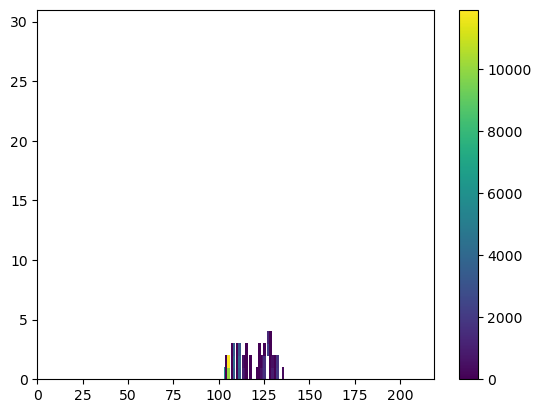

In [34]:
plt.pcolor(outflow_pos[55,14,:,:])
plt.colorbar()
print(np.nansum(np.nansum(outflow_pos[55,14,:,:],axis=1),axis=0))

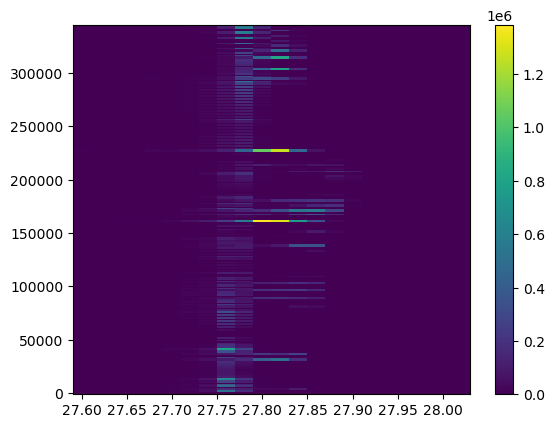

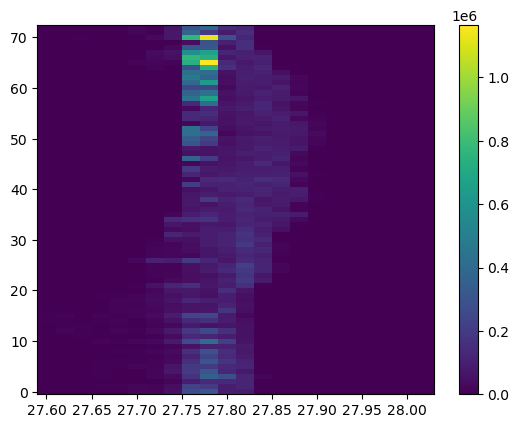

In [35]:
# now make some example plots

# density vs. distance outflow plot
plt.pcolormesh(density_classes,np.cumsum(dC),np.nansum(np.nansum(outflow_pos,2),0).T)
plt.colorbar()
plt.show()


# density vs. time outflow plot
plt.pcolormesh(density_classes,np.arange(0,73),np.nansum(np.nansum(outflow_pos,axis=3),axis=2))
plt.colorbar()


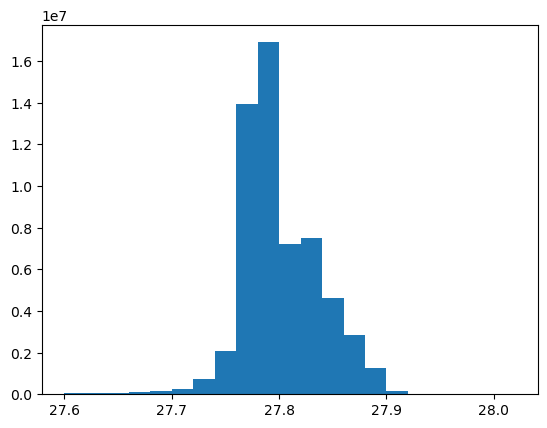

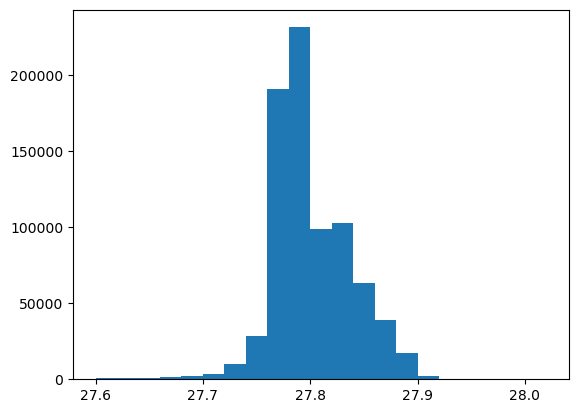

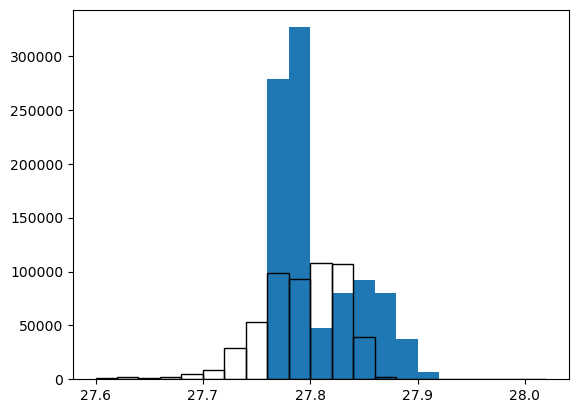

In [36]:
# annual integrated DSW export

plt.hist(density_classes,weights=np.nansum(np.nansum(np.nansum(outflow_pos,axis=3),axis=2),axis=0),bins=density_classes)
plt.show()

# annual MEAN DSW export
plt.hist(density_classes,weights=np.nanmean(np.nansum(np.nansum(outflow_pos,axis=3),axis=2),axis=0),bins=density_classes)
plt.show()

# winter mean vs. summer mean DSW export
plt.hist(density_classes,weights=np.nanmean(np.nansum(np.nansum(outflow_pos[winter_period],axis=3),axis=2),axis=0),bins=density_classes,color='C0', stacked=True)
plt.hist(density_classes,weights=np.nanmean(np.nansum(np.nansum(outflow_pos[summer_period],axis=3),axis=2),axis=0),bins=density_classes,color='C1', stacked=True, fill=False)

plt.show()


In [37]:
ds

<xarray.Dataset>
Dimensions:            (tracer: 2, boundary: 4, s_rho: 31, s_w: 32,
                        eta_rho: 750, xi_rho: 900, xi_u: 899, eta_v: 749,
                        ocean_time: 365, day: 365, dayofyear: 73)
Coordinates: (12/17)
  * s_rho              (s_rho) float64 -0.9839 -0.9516 ... -0.04839 -0.01613
  * s_w                (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.03226 0.0
    x_rho              (eta_rho, xi_rho) float64 1.501e+06 ... 3.299e+06
    y_rho              (eta_rho, xi_rho) float64 1e+03 1e+03 ... 1.499e+06
    x_u                (eta_rho, xi_u) float64 1.502e+06 1.504e+06 ... 3.298e+06
    y_u                (eta_rho, xi_u) float64 1e+03 1e+03 ... 1.499e+06
    ...                 ...
    lon_rho            (eta_rho, xi_rho) float64 89.96 89.96 ... 65.55 65.56
    lat_rho            (eta_rho, xi_rho) float64 -76.25 -76.23 ... -57.53 -57.51
    z_w0               (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.0 0.0
    z_rho0             (s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... -3.873
  * day                (day) int64 356 361 1 6 11 16 ... 326 331 336 341 346 351
  * dayofyear          (dayofyear) int64 1 6 11 16 21 26 ... 341 346 351 356 361
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/99)
    ntimes             int32 131400
    ndtfast            int32 40
    dt                 float64 240.0
    dtfast             float64 6.0
    dstart             datetime64[ns] 2007-01-01
    nHIS               int32 1800
    ...                 ...
    salt_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 nan ... 34.3
    temp_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 nan ... 1.206
    u_rho_doy          (dayofyear, s_rho, eta_rho, xi_rho) float32 nan ... nan
    v_rho_doy          (dayofyear, s_rho, eta_rho, xi_rho) float32 nan ... 0....
    sigma_0_doy        (dayofyear, s_rho, eta_rho, xi_rho) float64 nan ... 27.47
    dz                 (s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... 13.88 13.88
Attributes: (12/35)
    file:              roms_avg_0049.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             Amery Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 4.1, Thursday - October 17, 2024 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       AMERY, ADD_FSOBC, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL,...

In [38]:
# grab outflow > 27.8 and ?27.9

integrated_outflow_pos = np.nansum(np.nansum(outflow_pos,axis=3),axis=2)

dens_integrated_outflow_pos_278 = integrated_outflow_pos.copy()
dens_integrated_outflow_pos_2788 = integrated_outflow_pos.copy()

density_mask_278 = np.tile(density_classes>27.8,(len(ds.dayofyear),1))
density_mask_2788 = np.tile(density_classes>27.88,(len(ds.dayofyear),1))

dens_outflow_278_ts = np.nansum(dens_integrated_outflow_pos_278*density_mask_278,axis=1)
dens_outflow_2788_ts = np.nansum(dens_integrated_outflow_pos_2788*density_mask_2788,axis=1)

Text(0.5, 0, 'Day of year')

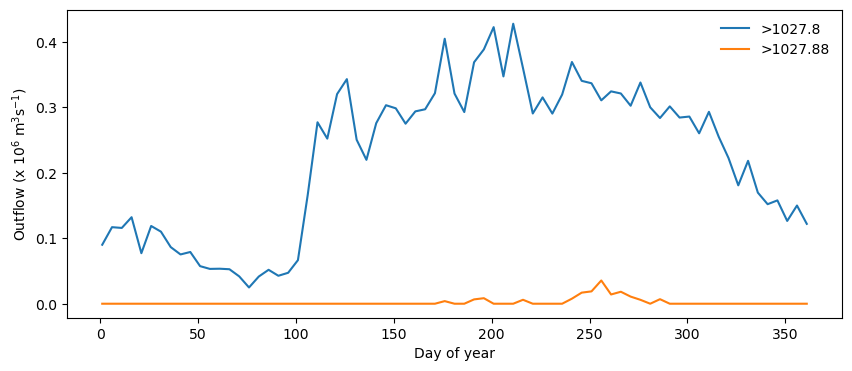

In [39]:
fig = plt.figure(figsize=(10,4))
ax=fig.add_subplot(gs[0,0])
ax.plot(ds.dayofyear,dens_outflow_278_ts/1e6,label='>1027.8')
ax.plot(ds.dayofyear,dens_outflow_2788_ts/1e6,label='>1027.88')
ax.legend(frameon=False)
ax.set_ylabel('Outflow (x 10$^6$ m$^3$s$^{-1}$)')
ax.set_xlabel('Day of year')

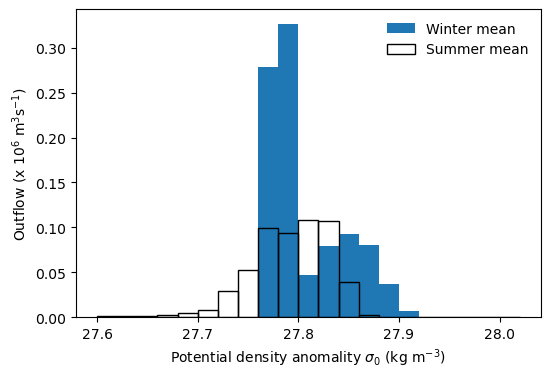

In [40]:
fig = plt.figure(figsize=(6,4))
ax=fig.add_subplot(gs[0,0])
ax.hist(density_classes,weights=np.nanmean(np.nansum(np.nansum(outflow_pos[winter_period],axis=3),axis=2),axis=0)/1e6,bins=density_classes,color='C0', stacked=True,label='Winter mean')
ax.hist(density_classes,weights=np.nanmean(np.nansum(np.nansum(outflow_pos[summer_period],axis=3),axis=2),axis=0)/1e6,bins=density_classes,color='C1', stacked=True, fill=False,label='Summer mean')
ax.set_ylabel('Outflow (x 10$^6$ m$^3$s$^{-1}$)')
ax.set_xlabel('Potential density anomality $\sigma_0$ (kg m$^{-3}$)')
ax.legend(frameon=False)

In [41]:
outflow_pos_da = xr.DataArray(outflow_pos,
                              coords={'dayofyear':ds.dayofyear,'dens_class':density_classes,'s_rho':ds.s_rho,'dC':dC},
                              dims=["dayofyear","dens_class","s_rho","dC"])
outflow_pos_da.to_netcdf('../data/proc/'+prefix_name+'_outflow_pos.nc')

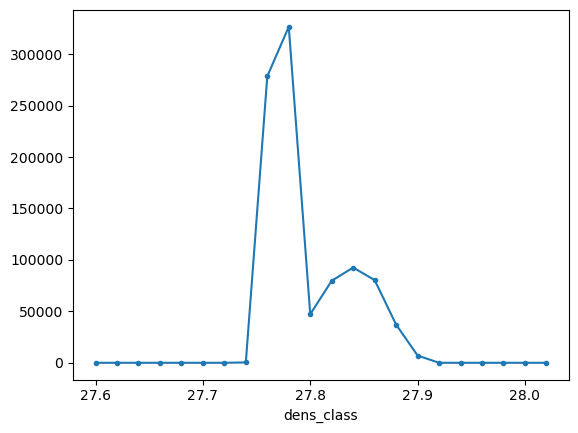

In [68]:
outflow_pos_da.isel(dayofyear=winter_period).sum(dim={'s_rho','dC'}).mean(dim={'dayofyear'}).plot(marker='.')

In [69]:
outflow_pos_da.isel(dayofyear=winter_period_doy).where(outflow_pos_da.dens_class>27.8).mean(dim={'dayofyear'}).sum(dim={'s_rho','dC','dens_class'}).values/1e6

0.5533091278533819